## Part 3 ‐ Predictive modeling
### Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load the data
ultimate_df = pd.read_json('ultimate_data_challenge.json')

In [3]:
# Examine the data
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
ultimate_df.count()

city                      50000
trips_in_first_30_days    50000
signup_date               50000
avg_rating_of_driver      41878
avg_surge                 50000
last_trip_date            50000
phone                     49604
surge_pct                 50000
ultimate_black_user       50000
weekday_pct               50000
avg_dist                  50000
avg_rating_by_driver      49799
dtype: int64

In [5]:
# Check for missing values
missing_values = ultimate_df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64


In [6]:
# 16% of the avg_rating_of_driver is missing. We could drop these rows or impute a value. 
# In this instance we will impute the missing values using the median. after evaluation the model, 
#    it would be a good idea to drop these rows or the column and evaluate the model again with the 
#     dropped rows/column and check if there is a noticable difference in the model performance. 
#     Then a decision would need to be made as to which model to use. 
# Calculate median of avg_rating_of_driver
median_of_driver_rating = ultimate_df['avg_rating_of_driver'].median()

# Fill missing values with the median
ultimate_df['avg_rating_of_driver'].fillna(median_of_driver_rating, inplace=True)

In [7]:
# 0.4% of the avg_rating_by_driver is missing we will impute the missing values using the median. 
# Calculate median of avg_rating_of_driver
median_by_driver_rating = ultimate_df['avg_rating_by_driver'].median()

# Fill missing values with the median
ultimate_df['avg_rating_by_driver'].fillna(median_by_driver_rating, inplace=True)

In [8]:
# 0.8% of the phone type is missing so we will impute the values.
# Since the phone is a string object, we will use mode to replace the missing values.
# Calculate mode of phone column
mode_phone = ultimate_df['phone'].mode()[0] 

# Fill missing values with the mode
ultimate_df['phone'].fillna(mode_phone, inplace=True)

In [9]:
# Convert date columns to datetime format
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

In [10]:
# Exploratory Data Analysis and Visualization
# Calculate retention rate
active_users = ultimate_df[ultimate_df['last_trip_date'] >= (max(ultimate_df['last_trip_date']) - pd.Timedelta('30 days'))]
retention_rate = len(active_users) / len(ultimate_df)
print("Retention Rate:", retention_rate)

Retention Rate: 0.37608


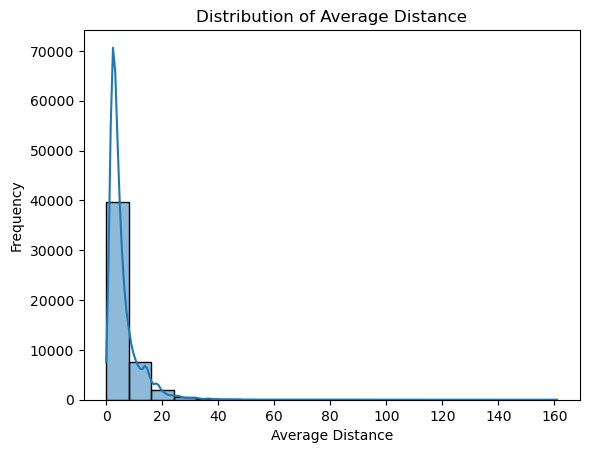

In [11]:
# Visualize some of the features
sns.histplot(ultimate_df['avg_dist'], bins=20, kde=True)
plt.title('Distribution of Average Distance')
plt.xlabel('Average Distance')
plt.ylabel('Frequency')
plt.show()

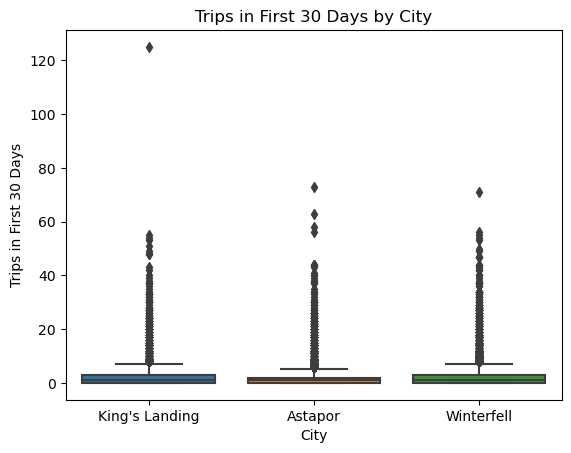

In [12]:
# Plot 
sns.boxplot(x='city', y='trips_in_first_30_days', data=ultimate_df)
plt.title('Trips in First 30 Days by City')
plt.xlabel('City')
plt.ylabel('Trips in First 30 Days')
plt.show()

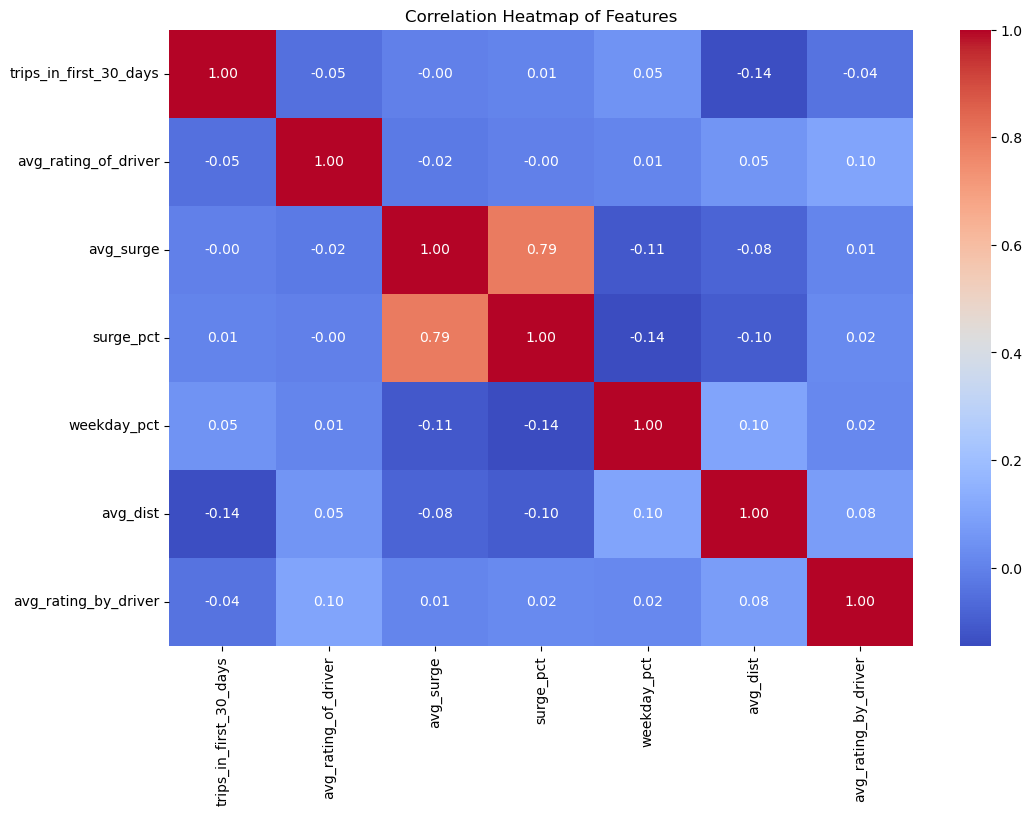

In [13]:
# Exclude non-numeric columns
numeric_cols = ultimate_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

In [14]:
# Now feature engineering and model building
# Convert categorical variables to dummy variables so they can be used in the model
ultimate_df = pd.get_dummies(ultimate_df, columns=['city', 'phone', 'ultimate_black_user'])

In [15]:
# Calculate target variable: active in 6th month
ultimate_df['active_6th_month'] = (ultimate_df['last_trip_date'] >= (ultimate_df['signup_date'] + pd.DateOffset(months=5))).astype(int)

In [16]:
# Select features and target variable
X = ultimate_df.drop(['signup_date', 'last_trip_date', 'active_6th_month'], axis=1)
y = ultimate_df['active_6th_month']

In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98)

In [18]:
# Build a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=98)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=98)

In [19]:
# Predict on test set
y_pred = rf_classifier.predict(X_test)

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7804


In [21]:
# Create classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7573
           1       0.56      0.46      0.50      2427

    accuracy                           0.78     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.77      0.78      0.77     10000

Confusion Matrix:
[[6687  886]
 [1310 1117]]


In [22]:
# List the important features
feature_importances = rf_classifier.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                      Feature  Importance
5                    avg_dist    0.304252
4                 weekday_pct    0.148781
6        avg_rating_by_driver    0.104531
1        avg_rating_of_driver    0.090832
3                   surge_pct    0.090646
0      trips_in_first_30_days    0.088169
2                   avg_surge    0.081654
8         city_King's Landing    0.024131
11               phone_iPhone    0.012844
7                city_Astapor    0.011640
12  ultimate_black_user_False    0.011619
10              phone_Android    0.011304
13   ultimate_black_user_True    0.010986
9             city_Winterfell    0.008610


The top 3 features used by the model:
1: avg_dist: the average distance in miles per trip taken in the first 30 days after signup
2: weekday_pct: the percent of the user’s trips occurring during a weekday
3: avg_rating_by_driver: the rider’s average rating over all of their trips

The model has an accuracy of approximately 78%, meaning it correctly predicts the target variable (active in 6th month) for 78% of the samples in the test set.

Precision measures the proportion of correctly predicted positive cases (active in 6th month) among all cases predicted as positive. It means that out of all the instances predicted to be active in their 6th month, only 56% are actually.

We should try some other methods to try and improve the accuracy, such as logistic regression, gradient boosting, or neural networks.